In [1]:
import pandas as pd
import numpy as np
from tabulate import tabulate
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

# Local application/library specific imports
import importlib
import sys
import os
base_path = 'C:/Users/Henri/Emilie/Thesis'
sys.path.append(base_path + '/code')
import project_functions as pf
importlib.reload(pf) # Reloading the local module 

# Reloading the local module 
importlib.reload(pf)

<module 'project_functions' from 'C:\\Users/Henri/Emilie/Thesis/code\\project_functions.py'>

In [2]:
# Load data
df_test = pd.read_csv(base_path + f'/data/testZR_v3_31.csv')
df_test['R_mm_per_h'] = np.array(df_test['R'] * 60) # Convert mm/min to mm/h

# Remove nans
df_test = df_test.dropna(subset=['dBZ', 'R', 'Z'])

# Convert timestamp to datetime and remove low quality observations
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test = df_test[df_test['timestamp'].dt.minute % 10 == 0]

# Valid evaluation idx for evaluation
valid_idx = (df_test['R'] * 60 > 0) & (df_test['Z'] > 0)  & ~df_test['R'].isnull() & ~df_test['Z'].isnull()

# Set invalid rows to zero
df_test.loc[~valid_idx, ['R', 'Z']] = 0

In [3]:
R_pred_MP = pf.Z_to_R_marshall_palmer(df_test['Z'])[valid_idx]
R_pred_PINN_fixedAB = np.load('PINN_fixedAB.npy')
R_pred_FFNN_AB = np.load('FFNN-AB.npy')
R_pred_FFNN_R = np.load('FFNN-R.npy')
R_pred_PINN_R_AB = np.load('PINN-Varying.npy')
R_pred_PINN_R_A200_B16 = np.load('PINN_fixed_A200_B1.6.npy')
#R_pred_PINN_R_AB_sampling = np.load('PINN-Sampling.npy')
R_pred_PINN_R_AB_sampling2 = np.load('PINN-Sampling2.npy')
#R_pred_2S_R = np.load('2stagePINNR.npy')
#R_pred_2S_AB = np.load('2stagePINNAB.npy')


rain_rates = [R_pred_MP, 
              R_pred_FFNN_R,  R_pred_FFNN_AB, 
              R_pred_PINN_fixedAB, 
              R_pred_PINN_R_A200_B16, R_pred_PINN_R_AB, 
              R_pred_PINN_R_AB_sampling2]
model_names = ['Marshall Palmer (A=200, B=1.6)',  
               'FFNN-R/W-MSE', 'FFNN-AB/MSE', 
               'PINN-R/W-MSE (A=190, B=3.71)', 'PINN-R/W-MSE (A=200, B=1.6)', 'PINN-RAB/W-MSE', 
               'PINN-RAB/W-MSE (Sampling)']

# Compute error metrics only on valid idx
error_metrics = []
for R_pred in rain_rates:
    valid_predictions = R_pred
    valid_true = df_test['R_mm_per_h'].loc[valid_idx].values

    # Calculate error metrics
    rmse = np.sqrt(mean_squared_error(valid_true, valid_predictions))
    mae = mean_absolute_error(valid_true, valid_predictions)
    me = np.mean(valid_predictions - valid_true)
    
    error_metrics.append((rmse, mae, me))

# Create a DataFrame for better visualization
error_df = pd.DataFrame(error_metrics, columns=['RMSE', 'MAE', 'ME'])

In [4]:
error_df

,RMSE,MAE,ME
0,3.538675,1.353346,0.386718
1,2.459136,0.997149,0.056656
2,2.557095,0.935653,-0.415905
3,2.607495,0.912025,-0.287097
4,2.424624,0.970399,-0.074440
5,2.468128,1.072181,0.274306
6,5.185364,2.638221,2.245210


In [5]:
# Define rain intensity bins
bins = [0.5, 2, 6, 10, 18, 30, np.inf]
labels = ['Weak rain\n(0.5-2 mm/h)', 'Moderate rain\n(2-6 mm/h)', 
          'Heavy rain\n(6-10 mm/h)', 'Very heavy rain\n(10-18 mm/h)', 'Shower\n(18-30 mm/h)', 'Cloudburst\n(>30 mm/h)']

# Bin the R_true values
df_test['rain_bin'] = pd.cut(df_test['R_mm_per_h'], bins=bins, labels=labels, right=False)

# Initialize a dictionary to store the error metrics
error_dict = {
    'Model': [],
    'Rain Bin': [],
    'RMSE': [],
    'MAE': [],
    'ME': []
}



# Calculate the total absolute error for each bin
for i, R_pred in enumerate(rain_rates):
    df_test['R_pred_mm_per_h'] = 0
    df_test.loc[valid_idx, 'R_pred_mm_per_h'] = R_pred
    for label in labels:
        bin_data = df_test[(df_test['rain_bin'] == label) & valid_idx]
        rmse = np.sqrt(mean_squared_error(bin_data['R_mm_per_h'], bin_data['R_pred_mm_per_h']))
        mae = mean_absolute_error(bin_data['R_mm_per_h'],  bin_data['R_pred_mm_per_h'])
        me = np.mean(bin_data['R_pred_mm_per_h'] - bin_data['R_mm_per_h'])
        error_dict['Model'].append(model_names[i])
        error_dict['Rain Bin'].append(label)
        error_dict['RMSE'].append(rmse)
        error_dict['MAE'].append(mae)
        error_dict['ME'].append(me)
        
# Convert the dictionary to a DataFrame
error_df = pd.DataFrame(error_dict)

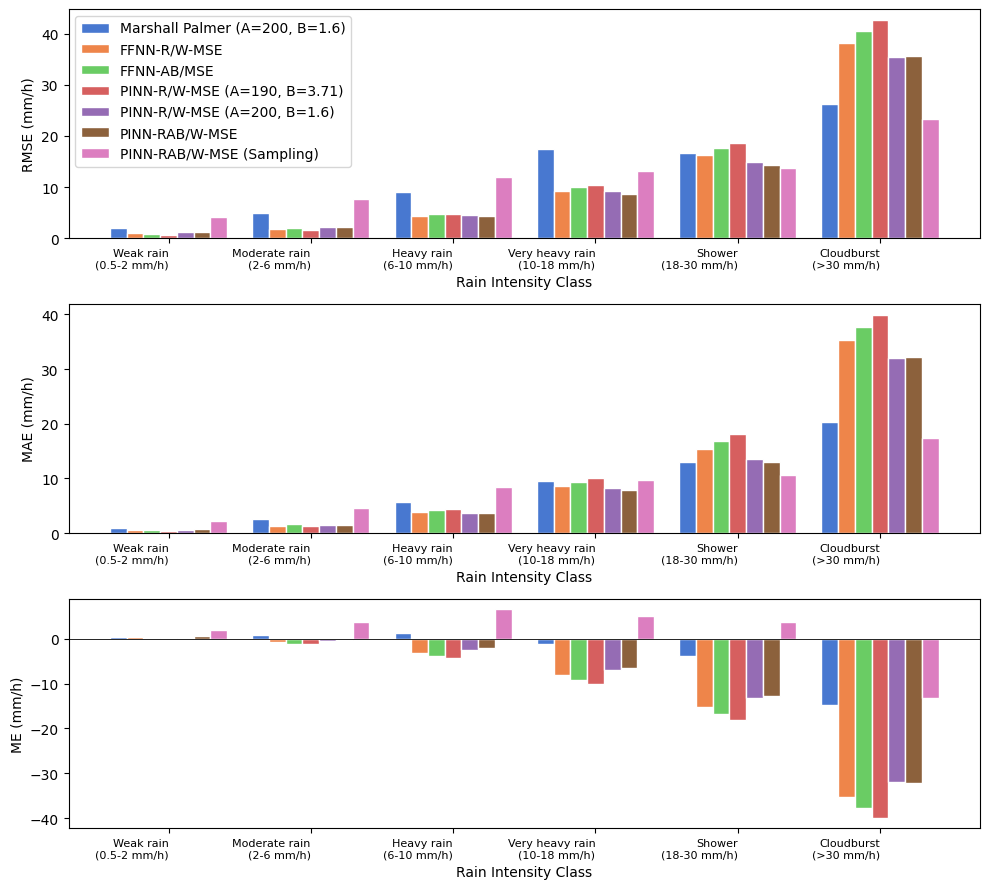

In [6]:
# Define the unique parameters and rain bins
parameters = error_df['Model'].unique()
rain_bins = error_df['Rain Bin'].unique()

# Set the width of the bars
bar_width = 0.2
spacer = 0.3 
# Set color palette
import seaborn as sns
colors = sns.color_palette("muted", len(parameters))

# Function to create the bar plots
def create_combined_bar_plots(metrics, titles, ylabels, filename):
    fig, axes = plt.subplots(3, 1, figsize=(10, 9))

    # Define the x positions for the groups
    x = np.arange(len(rain_bins)) * (len(parameters) * bar_width + spacer)

    for idx, (metric, title, ylabel) in enumerate(zip(metrics, titles, ylabels)):
        ax = axes[idx]
        for i, param in enumerate(parameters):
            subset = error_df[error_df['Model'] == param]
            values = subset[metric].values

            # Create bars for each parameter set
            ax.bar(x + i * bar_width, values, width=bar_width, label=param, color=colors[i], edgecolor = 'white')

        # Set labels and title
        ax.set_xlabel('Rain Intensity Class')
        ax.set_ylabel(ylabel)
        #ax.set_title(title)
        ax.set_xticks(x + bar_width * (len(parameters) - 1) / 2)
        ax.set_xticklabels(rain_bins, ha='right', size=8)
        if idx == 0:  # Only show legend on the first plot
            ax.legend()
        ax.axhline(y=0, color='black', linestyle='-', linewidth=0.6)
    plt.tight_layout()
    plt.savefig(filename, bbox_inches='tight', pad_inches=0.01, dpi=300)
    plt.show()

# Create combined bar plots for each metric
metrics = ['RMSE', 'MAE', 'ME']
titles = ['RMSE', 'MAE', 'ME']
ylabels = ['RMSE (mm/h)', 'MAE (mm/h)', 'ME (mm/h)']
filename = 'M2error_metrics_intensity_combined.png'

create_combined_bar_plots(metrics, titles, ylabels, filename)

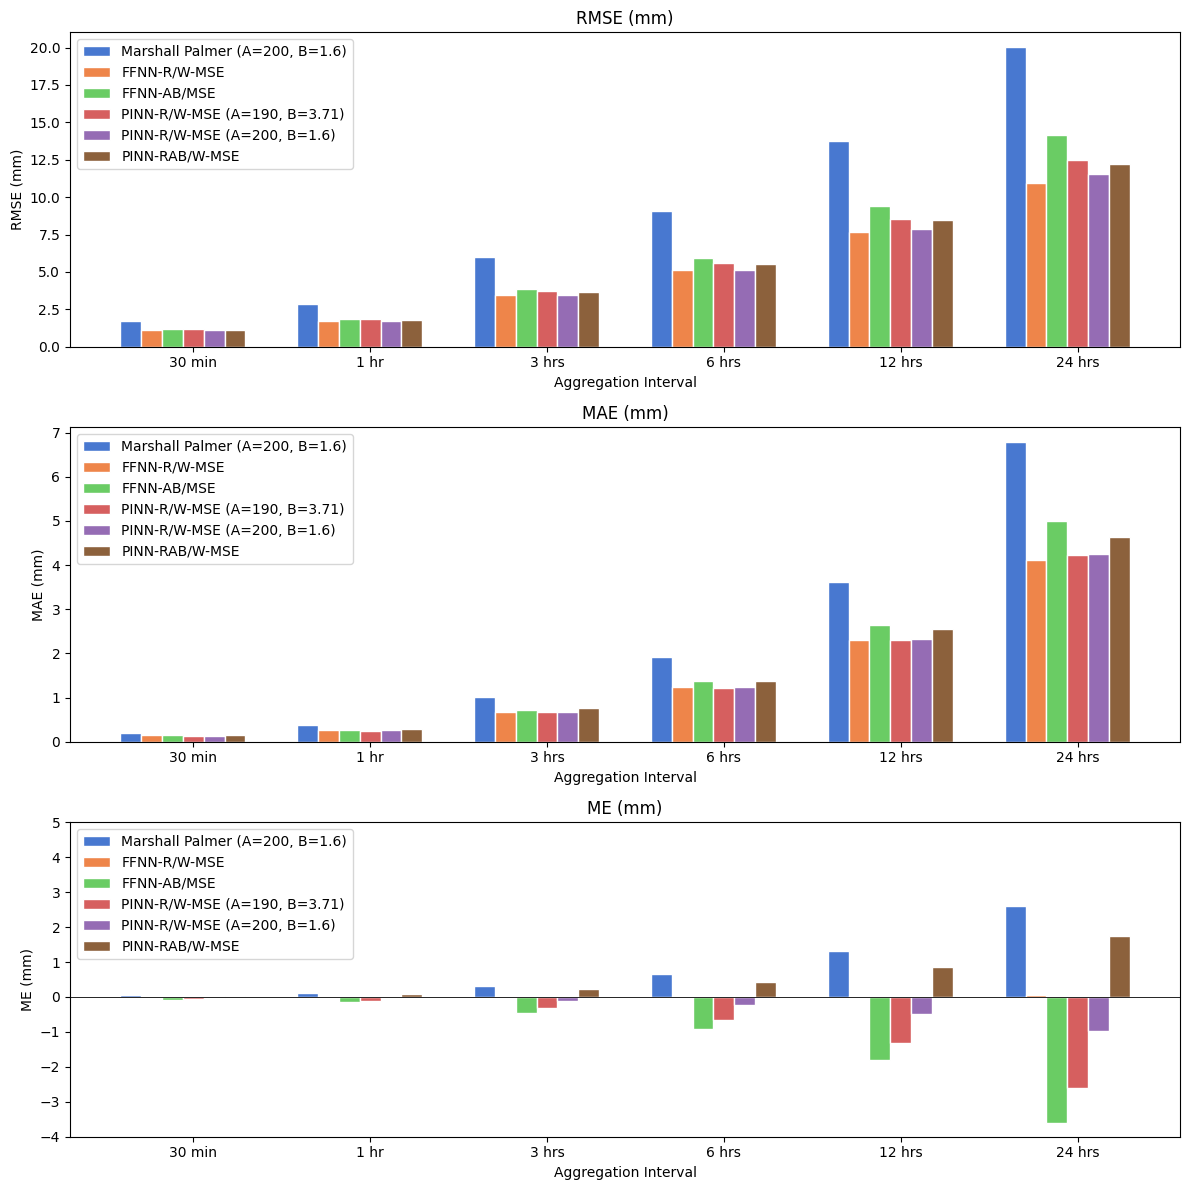

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import seaborn as sns

# Define RMSE, MAE, and ME functions using aliases
def rmse_metric(predictions, targets):
    return np.sqrt(mean_squared_error(targets, predictions))

def mae_metric(predictions, targets):
    return mean_absolute_error(targets, predictions)

def me_metric(predictions, targets):
    return np.mean(predictions - targets)

# Add predictions to df_test for each parameter combination
for i, R_pred in enumerate(rain_rates):
    df_test[f'R_pred_{i}'] = 0
    df_test.loc[valid_idx,  f'R_pred_{i}'] = R_pred

# Define aggregation intervals
intervals = ['30T', '60T', '180T', '360T', '720T', '1440T']  # Pandas resample intervals
interval_labels = ['30 min', '1 hr', '3 hrs', '6 hrs', '12 hrs', '24 hrs']

# Initialize storage for aggregated errors
aggregated_errors = []

# Compute aggregated errors for each parameter combination and interval
for i in range(len(rain_rates)):
    metrics = {}
    for interval in intervals:
        aggregated_errors_interval = {'RMSE': [], 'MAE': [], 'ME': []}
        for station_id, df_station in df_test.groupby('stationId'):
            df_station = df_station.set_index('timestamp')
            aggregated = df_station[[f'R_pred_{i}', 'R_mm_per_h']].resample(interval).sum()
            if len(aggregated) > 0:  # Ensure there is data after resampling
                aggregated_errors_interval['RMSE'].append(rmse_metric(aggregated[f'R_pred_{i}'], aggregated['R_mm_per_h']))
                aggregated_errors_interval['MAE'].append(mae_metric(aggregated[f'R_pred_{i}'], aggregated['R_mm_per_h']))
                aggregated_errors_interval['ME'].append(me_metric(aggregated[f'R_pred_{i}'], aggregated['R_mm_per_h']))
        
        metrics[f'RMSE_{interval}'] = np.mean(aggregated_errors_interval['RMSE'])
        metrics[f'MAE_{interval}'] = np.mean(aggregated_errors_interval['MAE'])
        metrics[f'ME_{interval}'] = np.mean(aggregated_errors_interval['ME'])
    
    aggregated_errors.append(metrics)
    
# Prepare data for plotting
bar_width = 0.2
x = np.arange(len(rain_bins)) * (len(parameters) * bar_width + spacer)
colors = sns.color_palette("muted", len(rain_rates))

fig, axs = plt.subplots(3, 1, figsize=(12, 12))

# Titles and labels for the subplots
titles = ['RMSE (mm)', 'MAE (mm)', 'ME (mm)']
y_labels = ['RMSE (mm)', 'MAE (mm)', 'ME (mm)']

for i, (title, y_label) in enumerate(zip(titles, y_labels)):
    ax = axs[i]
    
    # Plotting each set of parameters
    for j, R_pred in enumerate(rain_rates[:-1]):
        metric = titles[i].split()[0]  # RMSE, MAE, or ME
        error_values = [aggregated_errors[j][f'{metric}_{interval}'] for interval in intervals]
        ax.bar(x + j * bar_width, error_values, width=bar_width, label=f'{model_names[j]}', color=colors[j], edgecolor = 'white')
    
    # Setting x-axis labels and positions
    ax.set_xticks(x + bar_width * (len(rain_rates) - 1) / 2)
    ax.set_xticklabels(interval_labels)
    ax.set_xlabel('Aggregation Interval')
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend(loc='upper left')
    #ax.grid(True)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.6)
    
    if ax == axs[2]:
        ax.set_ylim(-4,5)
    
plt.tight_layout()
plt.savefig('m2error_metrics_aggregation_intervals.png', format='png', dpi=300)
plt.show()

In [8]:
df_test = pd.read_csv(base_path + f'/data/testZR_v3_31.csv')
df_test['R_mm_per_h'] = np.array(df_test['R'] * 60) # Convert mm/min to mm/h

# Remove nans
#df_test = df_test.dropna(subset=['dBZ', 'R', 'Z'])

# Convert timestamp to datetime and remove low quality observations
df_test['timestamp'] = pd.to_datetime(df_test['timestamp'])
df_test = df_test[df_test['timestamp'].dt.minute % 10 == 0]

# Valid evaluation idx for evaluation
valid_idx = (df_test['R'] * 60 > 0) & (df_test['Z'] > 0)  & ~df_test['R'].isnull() & ~df_test['Z'].isnull()

# Set invalid rows to zero
df_test.loc[~valid_idx, ['R', 'Z']] = 0

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
def Z_to_R_marshall_palmer(Z, A=200, B=1.6):
    Z = np.asarray(Z)
    R = (Z / A)**(1/B)
    return R



# Filter the data using valid_idx
df_test_filtered = df_test

# Ensure 'timestamp' is in datetime format
df_test_filtered['timestamp'] = pd.to_datetime(df_test_filtered['timestamp'])

# Convert rain rates from mm/h to mm for 5-minute intervals
df_test_filtered['R_mm'] = df_test_filtered['R_mm_per_h'] / 12

# Group by 'stationId' and 'timestamp', then compute the mean for each group
df_test_grouped = df_test_filtered.groupby(['stationId', 'timestamp'])['R_mm'].mean().reset_index()

# Compute cumulative sum of the true rain rates for each stationId
# Assuming df_test_filtered and df_test_grouped are already created

# Dictionary to store cumulative sums for each station
cumulative_rain_per_station = {}
stations = df_test_grouped['stationId'].unique()

plt.figure(figsize=(12, 6))

for station in stations:
    df_subset = df_test_grouped[df_test_grouped['stationId'] == station].sort_values('timestamp')
    cumulative_rain_per_station[station] = np.cumsum(df_subset['R_mm']).values

# Create a DataFrame with cumulative sums for each station
cumulative_rain_df = pd.DataFrame(cumulative_rain_per_station)

<Figure size 1200x600 with 0 Axes>

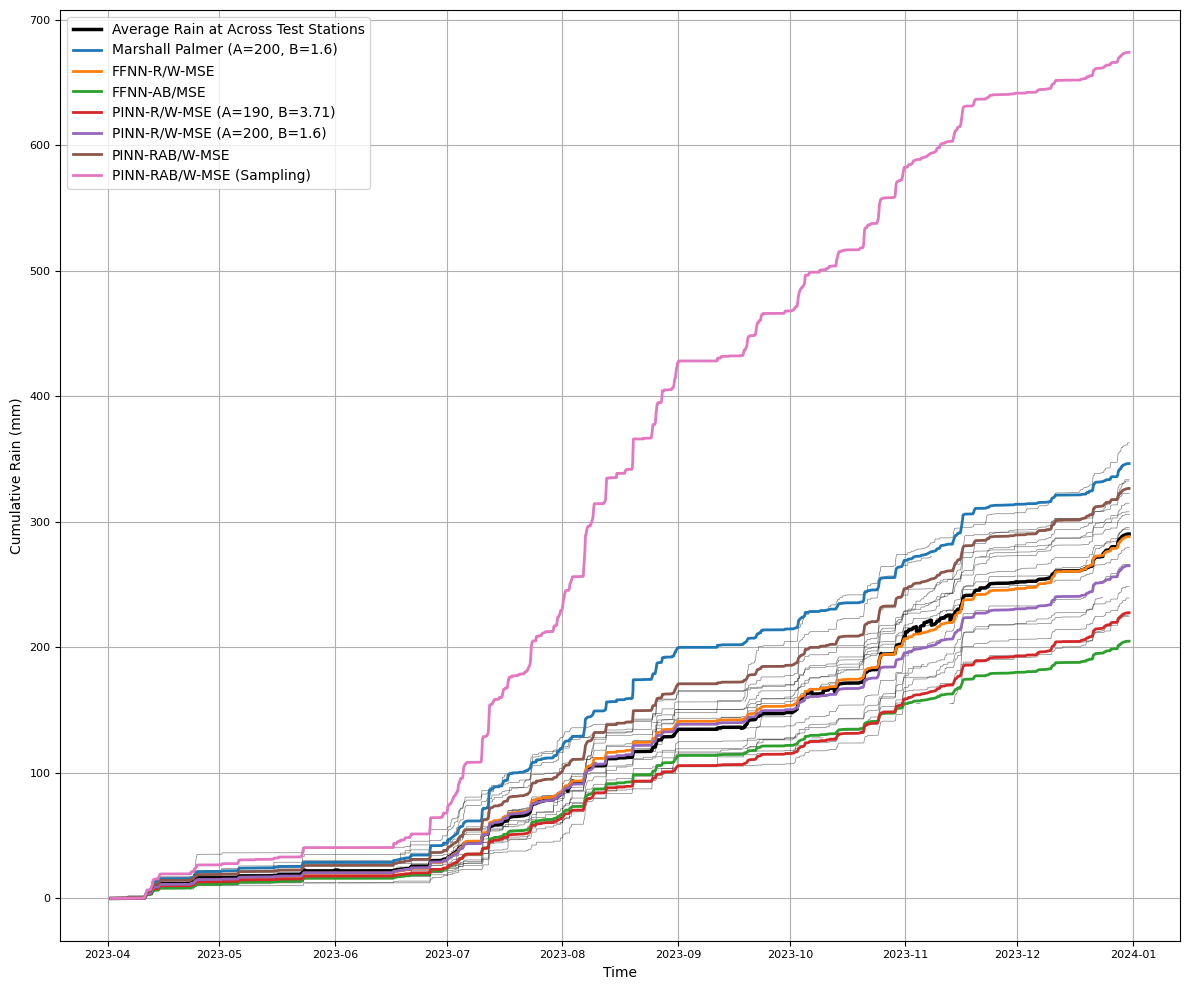

In [10]:
# Add timestamps to the DataFrame
timestamps = df_test_grouped[df_test_grouped['stationId'] == stations[0]].sort_values('timestamp')['timestamp'].values
cumulative_rain_df['timestamp'] = timestamps

# Set 'timestamp' as the index
cumulative_rain_df.set_index('timestamp', inplace=True)

# Calculate the average cumulative rain and add it as a new column
cumulative_rain_df['average'] = cumulative_rain_df.mean(axis=1)

plt.figure(figsize=(12, 10))

# Plot the cumulative rain for each station
for station in stations:
    df_subset = df_test_grouped[df_test_grouped['stationId'] == station].sort_values('timestamp')
    plt.plot(df_subset['timestamp'], cumulative_rain_per_station[station], lw=0.5, alpha=0.5, color='black')

# Plot the average cumulative rain
plt.plot(cumulative_rain_df.index, cumulative_rain_df['average'], color='black', linewidth=2.5, label='Average Rain at Across Test Stations')


# Compute and plot average cumulative rain for each model
for i, R_pred in enumerate(rain_rates):
    # Compute rain rates for each station
    df_test['R_pred_mm_per_h'] = 0
    df_test.loc[valid_idx, 'R_pred_mm_per_h'] = R_pred
    df_test['R_mm_model'] = df_test['R_pred_mm_per_h'] / 12  # Convert to mm for 5-minute intervals

    # Group by 'stationId' and 'timestamp', then compute the mean for each group
    df_test_grouped_model = df_test.groupby(['stationId', 'timestamp'])['R_mm_model'].mean().reset_index()

    # Compute cumulative sum for each station
    cumulative_rain_model_per_station = {}
    for station in stations:
        df_subset = df_test_grouped_model[df_test_grouped_model['stationId'] == station].sort_values('timestamp')
        cumulative_rain_model_per_station[station] = np.cumsum(df_subset['R_mm_model']).values

    # Create a DataFrame with cumulative sums for each station
    cumulative_rain_model_df = pd.DataFrame(cumulative_rain_model_per_station)

    # Add timestamps to the DataFrame
    cumulative_rain_model_df['timestamp'] = timestamps

    # Set 'timestamp' as the index
    cumulative_rain_model_df.set_index('timestamp', inplace=True)

    # Calculate the average cumulative rain and add it as a new column
    cumulative_rain_model_df['average'] = cumulative_rain_model_df.mean(axis=1)

    # Plot the average cumulative rain for the model
    plt.plot(cumulative_rain_model_df.index, cumulative_rain_model_df['average'], linewidth=2, label=f'{model_names[i]}')

# Plot formatting
plt.xlabel('Time')
plt.ylabel('Cumulative Rain (mm)')
#plt.title('Cumulative Rain for Different Stations and Models')
plt.legend()
plt.grid(True)
plt.xticks(size=8)
plt.yticks(size=8)
plt.tight_layout()

plt.savefig('M2.cumulative_rain_rates_models_average.png', format='png', dpi=300)
plt.show()